# POS Tagging with LSTM

We use the dataset from the [UD English EWT](https://github.com/UniversalDependencies/UD_English-EWT) to train a POS tagger with an LSTM model.

First, we load the three datasets: train, validation, and test. We use the `conllu` library to parse the datasets.


In [1]:
from conllu import parse

train_filename = "data/english/en_ewt-ud-train.conllu"
test_filename = "data/english/en_ewt-ud-test.conllu"
val_filename = "data/english/en_ewt-ud-dev.conllu"


def get_fields(line):
    words = line.split("\t")
    if len(words) < 4:
        return None
    return words[1], words[3], line


with open(train_filename, "r", encoding="utf-8") as file:
    train_sentences = parse(file.read())
with open(test_filename, "r", encoding="utf-8") as file:
    test_sentences = parse(file.read())
with open(val_filename, "r", encoding="utf-8") as file:
    val_sentences = parse(file.read())

train_sentences[:2]

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, ., metadata={newdoc id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000", sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001", newpar id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001", text: "Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border."}>, TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ], metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0002", text: "[This killing of a respected cleric will be causing us trouble for years to come.]"}>]

We preprocess all the datasets by getting only the words and the POS tags. We put all the sentences in a list and all the POS tags in another list of lists.


In [2]:
def preprocess_sentences(sentences):
    X_data = []
    y_data = []
    for sentence in sentences:
        parsed_sentence = []
        sentence_labels = []
        for token in sentence:
            if type(token["id"]) == int:
                parsed_sentence.append(token["form"])
                sentence_labels.append(token["upostag"])
        X_data.append(" ".join(parsed_sentence))
        y_data.append(sentence_labels)

    return X_data, y_data


X_train, y_train = preprocess_sentences(train_sentences)
X_test, y_test = preprocess_sentences(test_sentences)
X_val, y_val = preprocess_sentences(val_sentences)

print(f"Sentences: {X_train[6]}")
print(f"Class labels: {y_train[6]}")

Sentences: You wonder if he was manipulating the market with his bombing targets .
Class labels: ['PRON', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADP', 'PRON', 'NOUN', 'NOUN', 'PUNCT']


We calculate the number of classes and order it by alphabetical order. We obtain 17 different classes (as we expected, because we are following the [Universal POS tags](https://universaldependencies.org/u/pos/index.html) standard).


In [3]:
# Flatten y_data and convert to a set to get unique labels
class_names = sorted(list({label for sublist in y_train for label in sublist}))
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Create a dictionary mapping class names to class numbers
classes = dict(zip(class_names, range(num_classes)))

Number of classes: 17
Class names: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


We calculate some statistics to decide which parameters we have to use when designing. We observe that the average length of the sentences is aproximately 16 words and the standard deviation is 12.4. Also, we observe that there are not a lot of sentences with more than 100 words.


Max sentence length: 159
Mean sentence length: 16.31
Standard deviation of sentence length: 12.4


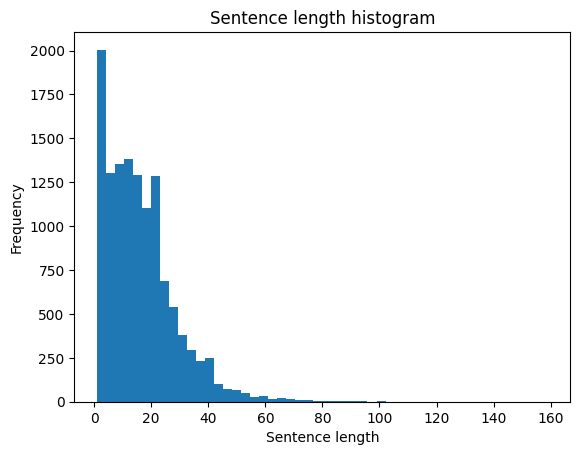

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the maximum length of the sentences
sentence_num_words = [len(sentence.split()) for sentence in X_train]
max_len = max(sentence_num_words)
print(f"Max sentence length: {round(max_len, 2)}")

mean_len = np.mean(sentence_num_words)
std_len = np.std(sentence_num_words)
print(f"Mean sentence length: {round(mean_len, 2)}")
print(f"Standard deviation of sentence length: {round(std_len, 2)}")

# Build an histogram of the number of words in the sentences
plt.hist(sentence_num_words, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.title("Sentence length histogram")
plt.show()

We calculate how many different words we have in the train set and in the test set: 19674 and 5629, respectively.


In [7]:
X_plain_train = {token for sentence in X_train for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_train)}")

X_plain_test = {token for sentence in X_test for token in sentence.split()}
print(f"Number of unique tokens: {len(X_plain_test)}")

Number of unique tokens: 19674
Number of unique tokens: 5629


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 2: Text tokenization
vocab_size = 1000  # Number of unique words
tokenizer = TextVectorization(output_mode="int", max_tokens=vocab_size, output_sequence_length=max_len)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)


y_train = pad_sequences(y_train, maxlen=max_len, padding="post", value=0)

# Step 3: Define the model
embedding_dim = 50  # Dimension of the embedding vector

model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
# LSTM layer
model.add(LSTM(units=embedding_dim))
# Output layer
model.add(Dense(num_classes, activation="softmax"))

# Step 4: Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

AttributeError: 'TextVectorization' object has no attribute 'fit_on_texts'